In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Optional
from torch import Tensor
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision
from glob import glob
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import re
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from  sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import CenterCrop

In [2]:
class DNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, device: torch.device) -> None:
        super(DNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, 200).to(device)
        self.bn1 = nn.BatchNorm1d(200).to(device)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(200, 100).to(device)
        self.bn2 = nn.BatchNorm1d(100).to(device)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(100, output_size).to(device)
        
        self._init_weights()

    def _init_weights(self) -> None:
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.normal_(param, mean=0, std=0.01)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, device: torch.device = None) -> None:
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
                
        self.weight_ih = nn.Parameter(torch.empty(4*hidden_size, input_size, device=device))
        self.weight_hh = nn.Parameter(torch.empty(4*hidden_size, hidden_size, device=device))
        
        self.bias = bias
        
        if self.bias:
            self.bias_ih = nn.Parameter(torch.empty(4*hidden_size, device=device))
            self.bias_hh = nn.Parameter(torch.empty(4*hidden_size, device=device))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        
        self.peephole_i = nn.Parameter(torch.empty(hidden_size, device=device))
        self.peephole_f = nn.Parameter(torch.empty(hidden_size, device=device))
        self.peephole_o = nn.Parameter(torch.empty(hidden_size, device=device))
        
        self._init_weights()

    def _init_weights(self) -> None:
        for param in self.parameters():
            nn.init.normal_(param, mean=0, std=0.01)
        nn.init.normal_(self.peephole_i, mean=0, std=0.01)
        nn.init.normal_(self.peephole_f, mean=0, std=0.01)
        nn.init.normal_(self.peephole_o, mean=0, std=0.01)
    
    def forward(self, input: Tensor, state: Tuple[Tensor, Tensor] = None) -> Tuple[Tensor, Tensor]:
        hx, cx = state
        gates = torch.mm(input, self.weight_ih.t()) + torch.mm(hx, self.weight_hh.t())
        if self.bias:
            gates += self.bias_ih + self.bias_hh
        
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)
        
        input_gate = torch.sigmoid(input_gate + self.peephole_i * cx)
        forget_gate = torch.sigmoid(forget_gate + self.peephole_f * cx)
        cell_gate = torch.tanh(cell_gate)
        
        cy = (forget_gate * cx) + (input_gate * cell_gate)
        
        output_gate = torch.sigmoid(output_gate + self.peephole_o * cy)
        
        hy = output_gate * torch.tanh(cy)
        return hy, cy
    
class LSTMBlock(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_cells: int, device: torch.device) -> None:
        super(LSTMBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_cells = num_cells
        self.device = device
        
        self.lstm_cells = nn.ModuleList([LSTMCell(self.input_size, hidden_size, device=device)
                                         if i == 0
                                         else LSTMCell(self.hidden_size, self.hidden_size, device=device)
                                         for i in range(self.num_cells)])
        
    def forward(self, input: Tensor, state: Tuple[Tensor, Tensor]=None)->Tuple[Tensor, Tensor]:
        batch_size = input.size(0)
        
        if state is None:
            zeros = torch.zeros(batch_size, self.hidden_size, device=self.device)
            state = (zeros, zeros)
            
        hx, cx = state
        
        outputs = []
        
        seq_len = input.size(1)
        for t in range(seq_len):
            x = input[:, t, :]
            for i, lstm_cell in enumerate(self.lstm_cells):
                hx, cx = lstm_cell(x, (hx, cx))
                x = hx
            outputs.append(hx)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, (hx, cx)
    
class MultiBlockLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_blocks: int, num_cells_per_block: int, device: torch.device) -> None:
        super(MultiBlockLSTM, self).__init__()
        self.device = device
        self.blocks = nn.ModuleList([
            LSTMBlock(input_size, hidden_size, num_cells_per_block, device)
            if i == 0
            else LSTMBlock(hidden_size, hidden_size, num_cells_per_block, device)
            for i in range(num_blocks)])

    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x, _ = block(x)
        return x

In [4]:
class CNN(nn.Module):
    def __init__(self, in_channels: int, output_size: int, device: torch.device) -> None:
        super(CNN, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size=3, stride=1, padding=1).to(device)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=2, stride=1, padding=0).to(device)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=2, stride=1, padding=0).to(device)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(30, output_size).to(device)
        
        self._init_weights()

    def _init_weights(self) -> None:
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.normal_(param, mean=0, std=0.01)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

In [5]:
class CLDNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 cnn_out_channels: int,
                 lstm_input_size: int,
                 lstm_hidden_size: int,
                 lstm_num_blocks: int,
                 lstm_num_cells_per_block: int,
                 dnn_output_size: int,
                 device: torch.device) -> None:
        super(CLDNN, self).__init__()
        self.device = device
        self.cnn = CNN(in_channels, cnn_out_channels, device)
        self.lstm = MultiBlockLSTM(lstm_input_size, lstm_hidden_size, lstm_num_blocks, lstm_num_cells_per_block, device)
        self.dnn = DNN(lstm_hidden_size, dnn_output_size, device)
    
    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_len, channels, height, width = x.size()

        cnn_out = []
        for t in range(seq_len):
            img = x[:, t, :, :, :]
            cnn_out.append(self.cnn(img))
            
        cnn_out = torch.stack(cnn_out, dim=1)
        
        lstm_out = self.lstm(cnn_out)
        
        last_output = lstm_out[:, -1, :]
        
        out = self.dnn(last_output)
        out = torch.sigmoid(out)
        return out

In [6]:
def load_img(dir):
    image = cv2.imread(dir)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap='gray')
    plt.axis('off')
    plt.show()
    return image_gray

def crop_center(img):
    img_resize = img[mid_x-224:mid_x+224, mid_y-224, mid_y+224]
    plt.imshow(img_resize, cmap='gray')
    plt.axis('off')
    plt.show()
    return img_resize

In [7]:
class SeqImageDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.image_paths = [
            sorted(glob(os.path.join(dir_path, '*.jpg')), key=self.custom_sort_key)
            for dir_path in self.X
        ]
        print(f'Loaded {len(self.image_paths)} sequences')
    
    @staticmethod
    def custom_sort_key(filename):
        # Trích xuất số frame từ tên file
        match = re.search(r'frame_(\d+)', filename)
        if match:
            return int(match.group(1))
        return filename  # Trả về nguyên tên file nếu không tìm thấy số frame

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_sequence = [
            read_image(img_path, mode=ImageReadMode.GRAY)
            for img_path in self.image_paths[idx]
        ]
        images = torch.stack(image_sequence, dim=0)
        label = torch.tensor(self.y.iloc[idx])
        if self.transforms:
            images = self.transforms(images)
        return images, label

In [8]:
def custom_collate_fn(batch):
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, labels = zip(*batch)
    max_len = max([s.shape[0] for s in sequences])
    padded_seqs = []
    for seq in sequences:
        seq_len = seq.shape[0]
        if seq_len < max_len:
            last_frame = seq[-1].unsqueeze(0)
            num_repeat = max_len - seq_len
            padding = last_frame.repeat(num_repeat, 1, 1, 1)
            padded = torch.cat([seq, padding], dim=0)
        else:
            padded = seq
        padded_seqs.append(padded)
    try:
        padded_seqs = torch.stack(padded_seqs, dim=0)
    except:
        print('error')
    labels = torch.stack(labels)
    return padded_seqs, labels

In [9]:
def get_stratified_test_set(X, y, n_samples_per_class=10):
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]

    test_indices_class_0 = np.random.choice(indices_class_0, n_samples_per_class, replace=False)
    test_indices_class_1 = np.random.choice(indices_class_1, n_samples_per_class, replace=False)

    test_indices = np.concatenate([test_indices_class_0, test_indices_class_1])

    mask = np.zeros(len(y), dtype=bool)
    mask[test_indices] = True

    X_test, X_remainder = X[mask], X[~mask]
    y_test, y_remainder = y[mask], y[~mask]

    return X_remainder, X_test, y_remainder, y_test

In [10]:
class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = labels
        self.batch_size = batch_size
        self.indices_0 = np.where(labels == 0)[0]
        self.indices_1 = np.where(labels == 1)[0]
        self.used_1 = 0

    def __iter__(self):
        np.random.shuffle(self.indices_0)
        np.random.shuffle(self.indices_1)
        
        n_batches = len(self.indices_1) // (self.batch_size // 2)
        
        for i in range(n_batches):
            batch = []
            batch.extend(self.indices_0[i * (self.batch_size // 2):(i + 1) * (self.batch_size // 2)])
            start = self.used_1
            end = self.used_1 + (self.batch_size // 2)
            batch.extend(self.indices_1[start:end])
            self.used_1 = end % len(self.indices_1)
            np.random.shuffle(batch)
            yield batch

    def __len__(self):
        return len(self.indices_1) // (self.batch_size // 2)

In [11]:
df = pd.read_csv('data.csv')
X, y = df['img_path'], df['label']
X_remainder, X_test, y_remainder, y_test = get_stratified_test_set(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.15, stratify=y_remainder)

In [46]:
y.value_counts()

label
1    83
0    28
Name: count, dtype: int64

: 

In [26]:
transform_pipeline = v2.Compose([
    v2.RandomResizedCrop((512, 512)),                 
    v2.RandomHorizontalFlip(p=0.5),        
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229]) 
])

train_dataset = SeqImageDataset(X_train, y_train, transforms=transform_pipeline)
val_dataset = SeqImageDataset(X_val, y_val, transforms=transform_pipeline)
test_dataset = SeqImageDataset(X_test, y_test, transforms=transform_pipeline)


Loaded 77 sequences
Loaded 14 sequences
Loaded 20 sequences


In [21]:
batch_size = 28
train_sampler = BalancedBatchSampler(y_train, batch_size)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [22]:
# next(iter(train_loader))

In [23]:
def train(model, train_loader, val_loader, epochs, optimzier, loss_fn, device):
    model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            train_loss += loss.item()
            optimzier.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+ 1}: Training Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}')
    return train_losses, val_losses
        

In [24]:
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    misclassified_indices = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            start_idx = batch_idx * data_loader.batch_size
            batch_misclassified = (predicted != y).nonzero(as_tuple=True)[0]
            misclassified_indices.extend(start_idx + batch_misclassified.cpu().numpy())
    acc = accuracy_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)
    
    return acc, cm, misclassified_indices

In [25]:
in_channels = 1
cnn_output_size = 300
lstm_input_size = cnn_output_size
lstm_hidden_size = 100
lstm_num_blocks = 10
lstm_num_cells_per_block = 10
dnn_output_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLDNN(
    in_channels=in_channels,
    cnn_out_channels=cnn_output_size,
    lstm_input_size=lstm_input_size, 
    lstm_hidden_size=lstm_hidden_size, 
    lstm_num_blocks=lstm_num_blocks,
    lstm_num_cells_per_block=lstm_num_cells_per_block,
    dnn_output_size=dnn_output_size,
    device=device)
model.load_state_dict(torch.load('weight/model.pt'))
optimizer = AdamW(model.parameters(), lr = 0.001)
loss_fn = CrossEntropyLoss()
epochs = 100

In [26]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs, optimizer, loss_fn, device)

KeyboardInterrupt: 

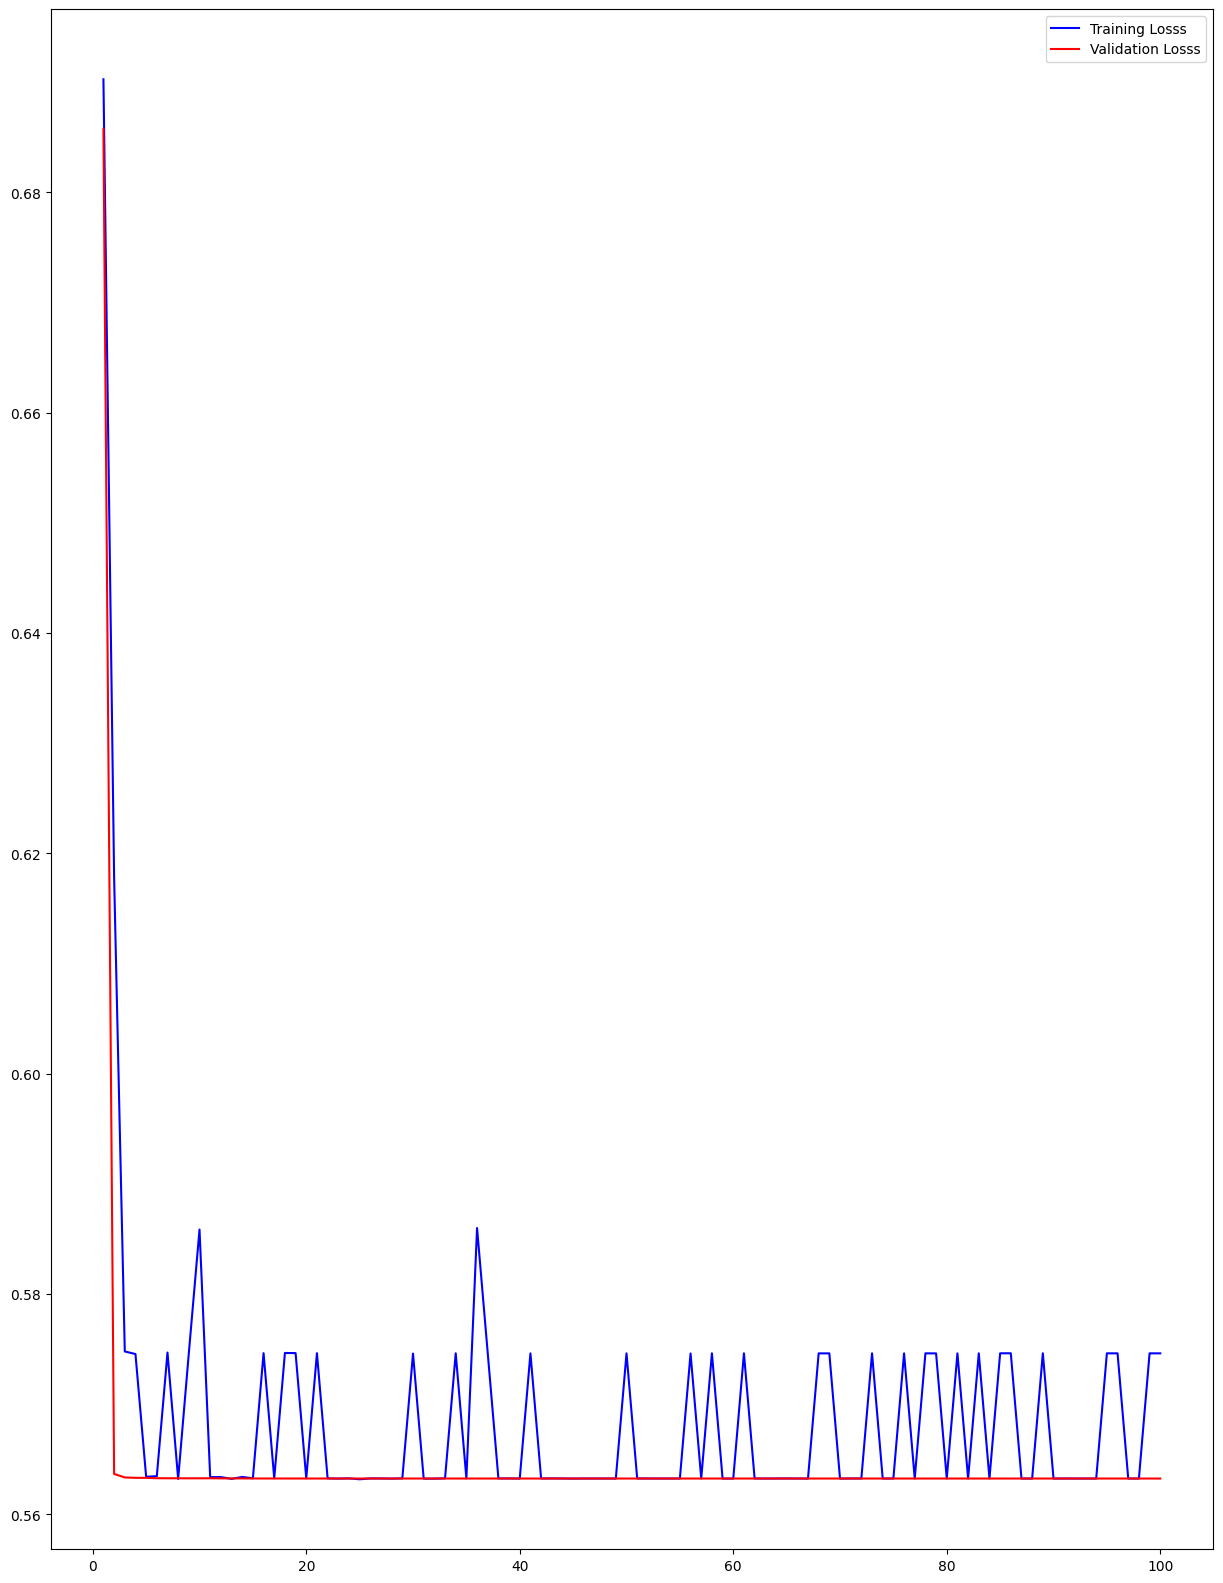

In [ ]:
plt.figure(figsize=(15, 20))
plt.plot(range(1, epochs+1), train_losses, c='blue', label='Training Losss')
plt.plot(range(1, epochs+1), val_losses, c='red', label='Validation Losss')
plt.legend()
plt.tight_layout()
plt.show()

Accuracy: 75.00%


/tmp/ipykernel_2133918/1563930177.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Negative', 'Positive'])
/tmp/ipykernel_2133918/1563930177.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Negative', 'Positive'])


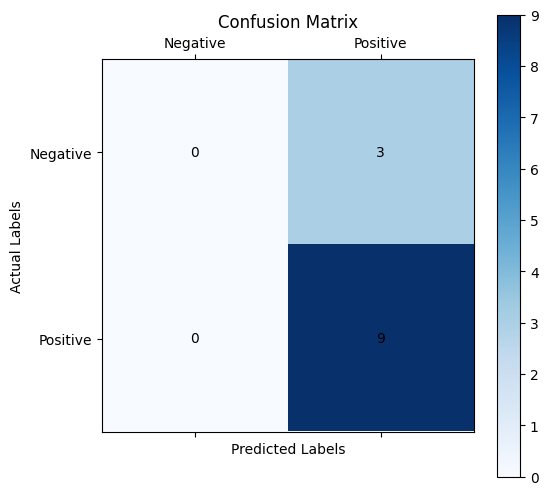

In [ ]:
accuracy, cm, misclassified_indices = evaluate(model, test_loader, device)

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['Negative', 'Positive'])
ax.set_yticklabels([''] + ['Negative', 'Positive'])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')
print(f"Accuracy: {accuracy * 100:.2f}%")
plt.show()


In [ ]:
torch.save(model.state_dict(),'weight/model.pt')

In [ ]:
yolo_model = YOLO('cell_detection/best.pt')
image_path = '/mnt/sdb2/DaiLe/CLDNN/img/Thang4/7_230026_well07_zid99_110/Thang4_230026_frame_92.jpg'
image = cv2.imread(image_path)
results = yolo_model(image)

for result in results:
    boxes = result.boxes  
    for box in boxes:
        
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        
        label = f'Class: {cls}, Conf: {conf:.2f}'
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(image)

In [ ]:


# Assume X and y are your features and labels
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=20, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

train_dataset = ImbalancedDataset(X_train, y_train)
val_dataset = ImbalancedDataset(X_val, y_val)
test_dataset = ImbalancedDataset(X_test, y_test)

batch_size = 38  # 19 from each class

train_sampler = BalancedBatchSampler(y_train, batch_size)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from ultralytics import YOLO

yolo_model = YOLO('cell_detection/best.pt')
image_path = '/mnt/sdb2/DaiLe/CLDNN/img/Thang3/4_230061_well04_zid04_49/Thang3_230061_frame_0.jpg'
image = cv2.imread(image_path)
results = yolo_model(image)

for result in results:
    boxes = result.boxes  
    for box in boxes:
        
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        
        label = f'Class: {cls}, Conf: {conf:.2f}'
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(image[y1:y2, x1:x2])